
**Install requirements**

In [0]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
# need tqdm version 4.30.0 for compatibility
!pip3 install 'tqdm==4.30.0'

  Using cached https://files.pythonhosted.org/packages/88/95/90e8c4c31cfc67248bf944ba42029295b77159982f532c5689bcfe4e9108/torch-1.3.1-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.3.1 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Using cached https://files.pythonhosted.org/packages/24/19/4804aea17cd136f1705a5e98a00618cb8f6ccc375ad8bfa437408e09d058/torch-1.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1


**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


**Analyzing data classes**

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9256, done.
remote: Total 9256 (delta 0), reused 0 (delta 0), pack-reused 9256
Receiving objects: 100% (9256/9256), 129.48 MiB | 38.64 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (9149/9149), done.


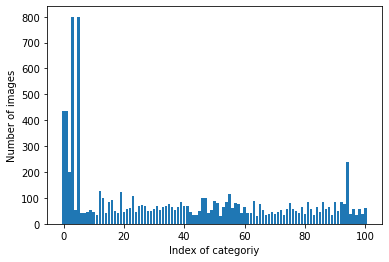

Total images: 8677


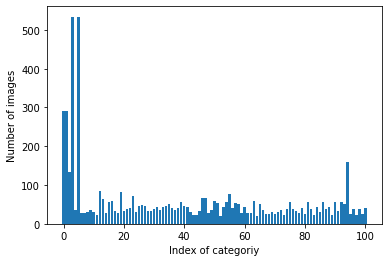

Training images: 5784


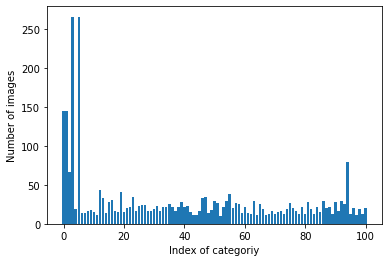

Test images: 2893


In [0]:
from collections import defaultdict

# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

PROJECT_DIR = 'Caltech101'
DATA_DIR = PROJECT_DIR + '/101_ObjectCategories'

# First lets take a general picture of the whole dataset
classes = sorted(os.listdir(os.path.join(DATA_DIR)))
classes.remove('BACKGROUND_Google')  # excluding the background class

classes_counter = {}.fromkeys(classes, 0)

for category in classes:
    classes_counter[category] = len(os.listdir(os.path.join(DATA_DIR, category)))

# Not the best representsation but it shows the distribution and imbalance of classes
plt.bar(list(range(0, len(classes_counter.keys()))), classes_counter.values())
plt.xlabel('Index of categoriy')
plt.ylabel('Number of images')
plt.show()
print('Total images: ' + str(sum(classes_counter.values())))


# Now lets see the training set
train_classes_counter = {}.fromkeys(classes, 0)   # Just in case if there is a class missing
train_path_list = open(os.path.join(PROJECT_DIR, 'train.txt')).readlines()
for path in train_path_list:
    category = path.split('/')[0]
    if 'BACKGROUND_Google' != category:
        train_classes_counter[category] = train_classes_counter[category] + 1

plt.bar(list(range(0, len(train_classes_counter.keys()))), train_classes_counter.values());
plt.xlabel('Index of categoriy')
plt.ylabel('Number of images')
plt.show()
print('Training images: ' + str(sum(train_classes_counter.values())))


# And finally the test set
test_classes_counter = {}.fromkeys(classes, 0)
test_path_list = open(os.path.join(PROJECT_DIR, 'test.txt')).readlines()
for path in test_path_list:
    category = path.split('/')[0]
    if 'BACKGROUND_Google' != category:
        test_classes_counter[category] = test_classes_counter[category] + 1

plt.bar(list(range(0, len(test_classes_counter.keys()))), test_classes_counter.values());
plt.xlabel('Index of categoriy')
plt.ylabel('Number of images')
plt.show()
print('Test images: ' + str(sum(test_classes_counter.values())))



It seems to maintain the distribution

**Implemented Dataset**

In [0]:
from torchvision.datasets import VisionDataset

from PIL import Image

import os
import os.path
import sys


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


class Caltech(VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)

        self.split = split # This defines the split you are going to use
                           # (split files are called 'train.txt' and 'test.txt')

        '''
        - Here you should implement the logic for reading the splits files and accessing elements
        - If the RAM size allows it, it is faster to store all data in memory
        - PyTorch Dataset classes use indexes to read elements
        - You should provide a way for the __getitem__ method to access the image-label pair
          through the index
        - Labels should start from 0, so for Caltech you will have lables 0...100 (excluding the background class) 
        '''

        BANNED_CLASS = 'BACKGROUND_Google'
        
        self.images_root = os.path.join(self.root, '101_ObjectCategories')
        # List of all classes sorted
        self.classes = sorted([d.name for d in os.scandir(self.images_root) if d.is_dir()])
        self.classes.remove(BANNED_CLASS)  # excluding the background class
        
        self.labels_dict = {i: self.classes[i] for i in range(len(self.classes))}

        with open(os.path.join(self.root, self.split + '.txt')) as f:
            path_list = f.read().splitlines() 

        self.images = []
        self.labels = []

        # Loading all the images with its label in memory
        for path in path_list:
            if BANNED_CLASS not in path:
                self.labels.append(self.classes.index(path.split('/')[0]))
                self.images.append(pil_loader(os.path.join(self.images_root, path)))

    def __getitem__(self, index):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''

        image, label = self.images[index], self.labels[index]

        # Applies preprocessing when accessing the image
        if self.transform is not None:
            image = self.transform(image)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return image, label
    
    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        length = len(self.images)
        return length
    
    def get_labels(self):
        return self.labels

    def get_labels_dict(self):
        return self.labels_dict


**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = int(256 / 1)     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3 * 20         # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = int(20)     # Total number of training epochs (iterations over dataset)
STEP_SIZE = int(4)      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.5          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
# Normalize ImageNet: https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/imagenet/main.py#L197-L198
mean_imagenet = [0.485, 0.456, 0.406]
std_imagenet = [0.229, 0.224, 0.225]

# Last for data aumentation:
train_transform = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                         transforms.ColorJitter(),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.CenterCrop(size=224),  
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=mean_imagenet, std=std_imagenet)])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=mean_imagenet, std=std_imagenet)])                                  

"""
Other sets for data augmentation:
train_transform_set1 = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                         transforms.RandomRotation(degrees=20),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.CenterCrop(size=224),  
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=mean_imagenet, std=std_imagenet)])

train_transform_set2 = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                         transforms.RandomRotation(degrees=10),
                                         transforms.ColorJitter(),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.CenterCrop(size=224),  
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=mean_imagenet, std=std_imagenet)])

########

For training from scratch:
train_transform = transforms.Compose([transforms.Resize(256),      
                                      transforms.CenterCrop(224),  
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

########

For transfer learning part:
train_transform = transforms.Compose([transforms.Resize(256),      
                                      transforms.CenterCrop(224),  
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean_imagenet, std=std_imagenet)])
])
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean_imagenet, std=std_imagenet)])
])

########
"""

'\nOther sets for data augmentation:\ntrain_transform_set1 = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),\n                                         transforms.RandomRotation(degrees=20),\n                                         transforms.RandomHorizontalFlip(),\n                                         transforms.CenterCrop(size=224),  \n                                         transforms.ToTensor(),\n                                         transforms.Normalize(mean=mean_imagenet, std=std_imagenet)])\n\ntrain_transform_set2 = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),\n                                         transforms.RandomRotation(degrees=10),\n                                         transforms.ColorJitter(),\n                                         transforms.RandomHorizontalFlip(),\n                                         transforms.CenterCrop(size=224),  \n                                         transform

**Prepare Dataset**

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

# Clone github repository with data
if not os.path.isdir('./Caltech101'):
    !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
    !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/'

def prepare_datasets(train_transform, eval_transform):
    # Prepare Pytorch train/test Datasets
    train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
    test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

    # Using Stratified strategy to split the datasets
    # It will mantain the classes distribution
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

    x_placeholder = np.zeros(len(train_dataset))
    y = train_dataset.get_labels()
    train_indexes, val_indexes = next(sss.split(x_placeholder, y))

    val_dataset = Subset(train_dataset, val_indexes)  # There was an error here, becouse it was rewirting the variable train_dataset
    train_dataset = Subset(train_dataset, train_indexes)  # just swap lines and solve it

    # Check dataset sizes
    print('Train Dataset: {}'.format(len(train_dataset)))
    print('Valid Dataset: {}'.format(len(val_dataset)))
    print('Test Dataset: {}'.format(len(test_dataset)))
    return train_dataset, val_dataset, test_dataset



Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9256, done.
remote: Total 9256 (delta 0), reused 0 (delta 0), pack-reused 9256
Receiving objects: 100% (9256/9256), 129.48 MiB | 28.95 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (9149/9149), done.


In [0]:
train_dataset, val_dataset, test_dataset = prepare_datasets(train_transform, eval_transform)


Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
def prepare_dataloaders(train_dataset, val_dataset, test_dataset, batch_size):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_dataloader, val_dataloader, test_dataloader


In [0]:
train_dataloader, val_dataloader, test_dataloader = prepare_dataloaders(train_dataset, val_dataset, test_dataset, BATCH_SIZE)

In order to check the dataloaders.

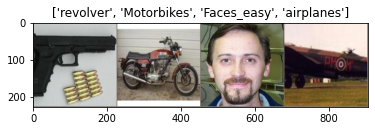

In [0]:
# As our images are normalized we have to denormalize them and 
# convert them to numpy arrays.
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std*img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) #Pause is necessary to display images correctly
    
images, labels = next(iter(train_dataloader))
grid_img = torchvision.utils.make_grid(images[:4], nrow=4)
imshow(grid_img, title=[train_dataloader.dataset.dataset.get_labels_dict()[int(x)] for x in labels[:4]])


**Prepare Network**

In [0]:
# net = alexnet() # Loading AlexNet model without be pretrained

net = alexnet(pretrained=True) # Loading AlexNet model pretrained with ImageNet

"""
For freeze the conv layers
for param in net.parameters():
    param.requires_grad = False
"""

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d
"""
For freeze the last fully connected layer
for param in net.classifier.parameters():
    param.requires_grad = False
"""

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

"""
In case we optimize over the parameters of the last fully connected layer
parameters_to_optimize = []
for name, param in net.named_parameters():
    if param.requires_grad == True:
        parameters_to_optimize.append(param)

In this case we optimize over the parameters of the convolutional layers
parameters_to_optimize = []
for name, param in net.named_parameters():
    if param.requires_grad == True:
        parameters_to_optimize.append(param)

"""

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Load logging**

In [0]:
from google.colab import drive

LOG_DIR = "runs"

# In order to save the results in google drive.
# drive.mount('/gdrive')
# !ln -s "/gdrive/My Drive/Colab Notebooks/runs" "/content/runs"

%load_ext tensorboard


In [0]:
%tensorboard --logdir /content/runs


**Train**

In [0]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

def train_model(net, log_folder, train_dataloader, optimizer, criterion, scheduler, num_epochs):
    # By default, everything is loaded to cpu
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

    cudnn.benchmark # Calling this optimizes runtime

    # TensorboardX summary writer
    now = datetime.now()
    params_save = 'lr: {}, g: {}, batch: {}, epochs: {}, step: {}'.format(
        scheduler.get_last_lr(), scheduler.gamma, train_dataloader.batch_size, 
        num_epochs, scheduler.step_size)
    
    log_dir = os.path.join(log_folder, now.strftime('%m-%d %H:%M:%S, ') + params_save)
    tbwriter = SummaryWriter(log_dir=log_dir)

    current_step = 0
    # Start iterating over the epochs
    for epoch in range(num_epochs):
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_last_lr()))

        # Iterate over the dataset
        for images, labels in train_dataloader:
            # Bring data over the device of choice
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            net.train() # Sets module in training mode

            # PyTorch, by default, accumulates gradients after each backward pass
            # We need to manually set the gradients to zero before starting a new iteration
            optimizer.zero_grad() # Zero-ing the gradients

            # Forward pass to the network
            outputs = net(images)

            # Compute loss based on output and ground truth
            loss = criterion(outputs, labels)

            # Log the information and add to tensorboard
            if current_step % LOG_FREQUENCY == 0:
                with torch.no_grad():
                    _, preds = torch.max(outputs, 1)
                    accuracy = torch.sum(preds == labels) / float(len(labels))

                    print('Epoch: {} \tStep: {} \tLoss: {:.4f} \tAcc: {}'
                        .format(epoch + 1, current_step, loss.item(), accuracy.item()))
                    tbwriter.add_scalar('loss', loss.item(), current_step)
                    tbwriter.add_scalar('accuracy', accuracy.item(), current_step)

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1

        # Step the scheduler
        scheduler.step() 

    tbwriter.close()

In [0]:
log_folder_tfs = 'runs/tfs_all'

train_model(net, log_folder_tfs, train_dataloader, optimizer, criterion, scheduler, NUM_EPOCHS)

Starting epoch 1/20, LR = [0.02]
Epoch: 1 	Step: 0 	Loss: 4.8439 	Acc: 0.01953125
Epoch: 1 	Step: 10 	Loss: 1.3740 	Acc: 0.67578125
Starting epoch 2/20, LR = [0.02]
Epoch: 2 	Step: 20 	Loss: 0.7205 	Acc: 0.84765625
Starting epoch 3/20, LR = [0.02]
Epoch: 3 	Step: 30 	Loss: 0.4337 	Acc: 0.87109375
Starting epoch 4/20, LR = [0.02]
Epoch: 4 	Step: 40 	Loss: 0.2912 	Acc: 0.8984375
Starting epoch 5/20, LR = [0.01]
Epoch: 5 	Step: 50 	Loss: 0.1619 	Acc: 0.9609375
Starting epoch 6/20, LR = [0.01]
Epoch: 6 	Step: 60 	Loss: 0.0382 	Acc: 0.99609375
Starting epoch 7/20, LR = [0.01]
Epoch: 7 	Step: 70 	Loss: 0.0317 	Acc: 0.98828125
Starting epoch 8/20, LR = [0.01]
Epoch: 8 	Step: 80 	Loss: 0.0211 	Acc: 0.9921875
Starting epoch 9/20, LR = [0.005]
Epoch: 9 	Step: 90 	Loss: 0.0145 	Acc: 0.99609375
Starting epoch 10/20, LR = [0.005]
Epoch: 10 	Step: 100 	Loss: 0.0507 	Acc: 0.99609375
Starting epoch 11/20, LR = [0.005]
Epoch: 11 	Step: 110 	Loss: 0.0202 	Acc: 0.98828125
Epoch: 11 	Step: 120 	Loss: 0.03

**Validation**

In [0]:
def val_model(net, val_dataloader):
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    for images, labels in tqdm(val_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = net(images)

        # Get predictions
        _, preds = torch.max(outputs.data, 1)

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataloader.dataset))

    print('\nValidation Accuracy: {}'.format(accuracy))

In [0]:
val_model(net, val_dataloader)

100%|██████████| 12/12 [00:07<00:00,  1.63it/s]


Validation Accuracy: 0.8423236514522822


**Test**

In [0]:
def test_model(net, test_dataloader):
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    for images, labels in tqdm(test_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = net(images)

        # Get predictions
        _, preds = torch.max(outputs.data, 1)

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(test_dataloader.dataset))

    print('\nTest Accuracy: {}'.format(accuracy))

In [0]:
test_model(net, test_dataloader)